In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile, expandvars

# data
zenith = 'random' # 'z20'  
table = 'regressor_5sgm_xy_flip.pickle'
path = f'{expandvars("$HOME")}/E4/irf_{zenith}/crab/'
dataset = join(path, table)

#model 
savename = 'regressor_zALL' 

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))

if '_CLEAN' in infotable:
    infotable = infotable.replace('_CLEAN', '')
    
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 20000


In [2]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(16000, 200, 200) (16000, 2)
Train dataset: 16000, (16000, 200, 200, 1)
Train labels: 16000, (16000, 2)

Test dataset: 4000, (4000, 200, 200, 1)
Test labels: 4000, (4000, 2)


In [3]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
24378,crab_19379,19379,0,100,100,175.356805,75.18494,177.08161,75.357027,0.471063,North_z20_N_5h_LST,2.5,6.731513


# Load model and weights

In [4]:
import tensorflow as tf

model = tf.keras.models.load_model(f'../models/crta_models/{savename}.keras')
model.summary()

2025-01-09 17:30:01.132337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 17:30:01.890726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 17:30:01.890759: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-09 17:30:07.226895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 6)       102       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 12)        300       
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 12)        588       
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 12)        588       
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 12)        588       
                                                        

In [5]:
%time
predictions = model.predict(test_data) * binning

CPU times: user 4 µs, sys: 9 µs, total: 13 µs
Wall time: 26.7 µs
125/125 [==============================] - 10s 49ms/step


In [6]:
predictions[idx], test_labels[idx] * binning

(array([98.471985, 89.491325], dtype=float32),
 array([116.6638822 ,  92.39841595]))

In [7]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# LABEL
label_pix = test_labels[idx][0] * binning, test_labels[idx][1] * binning
sky = w.pixel_to_world(label_pix[0], label_pix[1])
label_sky = sky.ra.deg, sky.dec.deg

# PREDICTION
pred_pix = predictions[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg


print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"label: {label_pix}")
print(f"prediction: {pred_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"label: {label_sky}")
print(f"prediction: {pred_sky}")

SEED: 19379
---- PIX
true: (array(116.6638822), array(92.39841595))
label: (116.66388219623727, 92.39841594605467)
prediction: [98.471985 89.491325]
---- SKY
true: (175.35680516620394, 75.18494030401693) 
label: (175.3568051662039, 75.18494030401692)
prediction: (177.13544334056505, 75.1186790021859)


In [8]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
histsize = (10, 8)
fs = 16
sz = 1.5e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-'),
                Line2D([0], [0], color='w', lw=1, ls='--')]

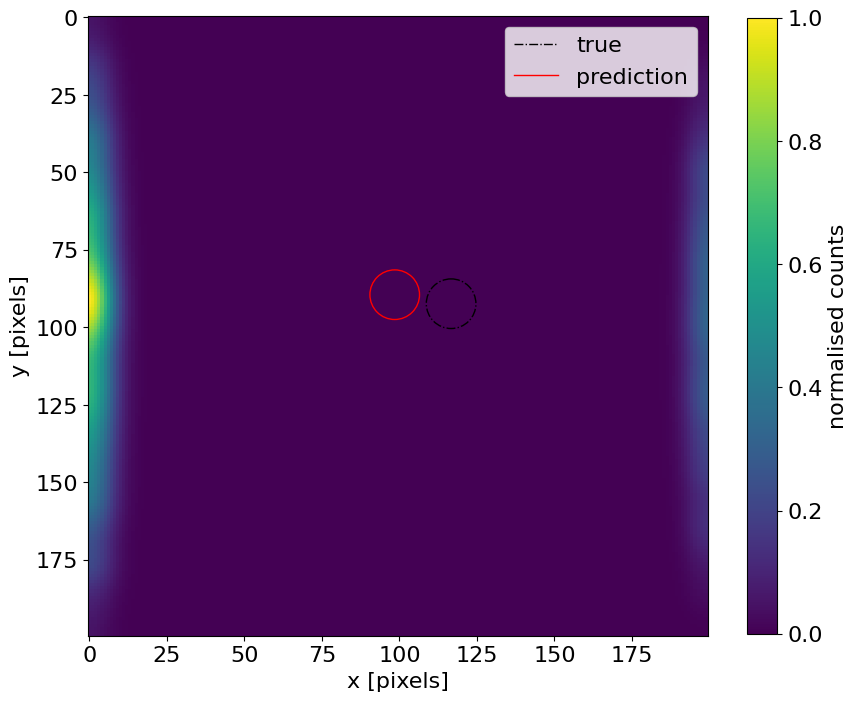

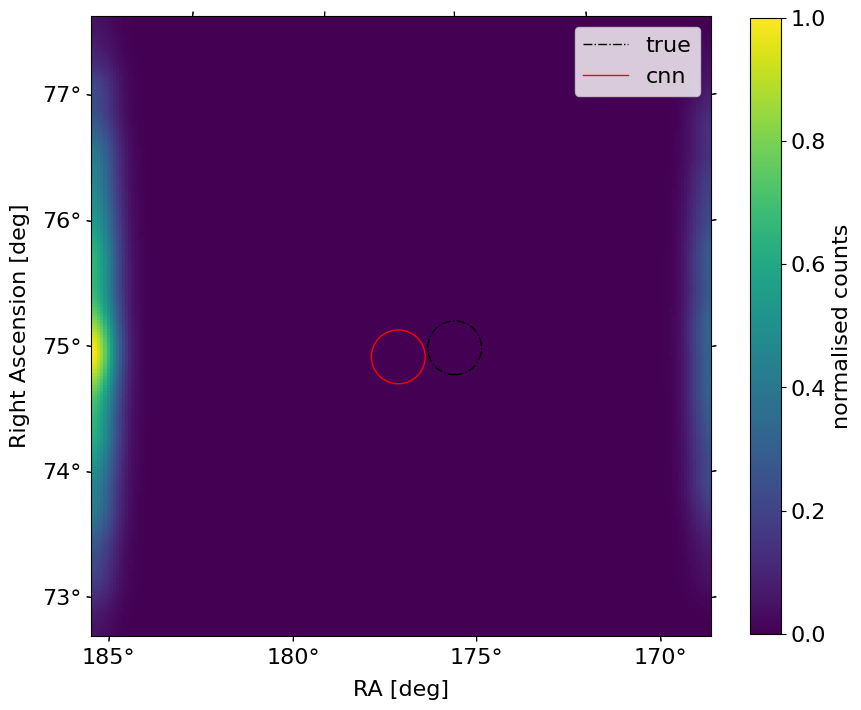

In [9]:
# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'counts map coordinates {seed}', fontsize=fs)
ax.legend(custom_lines[:2], ['true', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_pix.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Right Ascension [deg]', fontsize=fs)
ax.set_xlabel('RA [deg]', fontsize=fs)
#ax.set_title(f'counts map {seed}', fontsize=fs)
ax.legend(custom_lines[:2], ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_sky.png')
plt.show()

plt.show()

# Plot loss

In [10]:
loss = model.evaluate(test_data, test_labels, verbose=2)

125/125 - 6s - loss: 0.0167 - accuracy: 0.9570 - 6s/epoch - 50ms/step


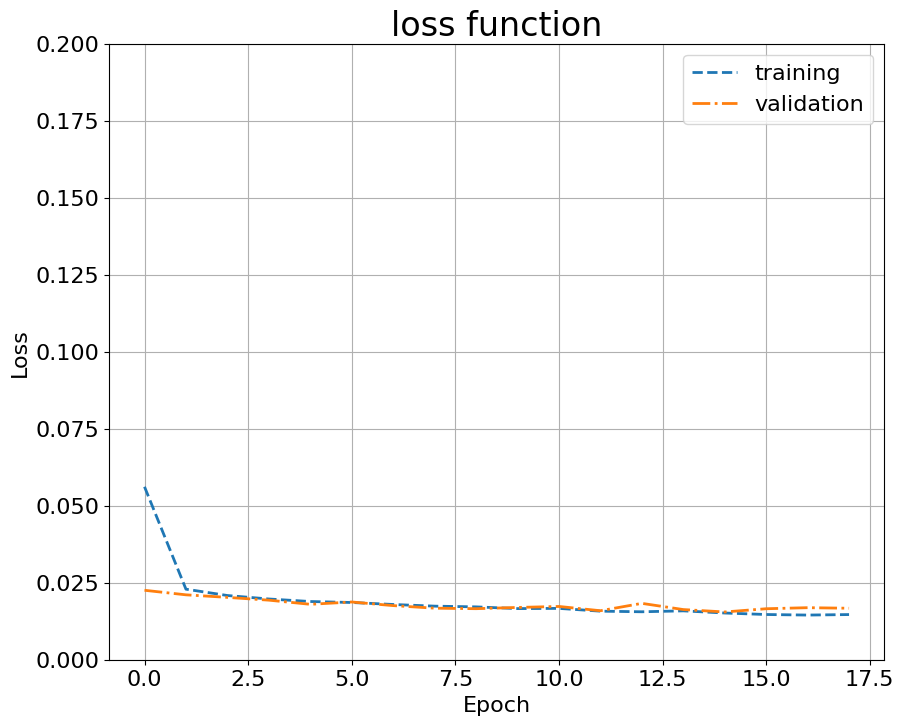

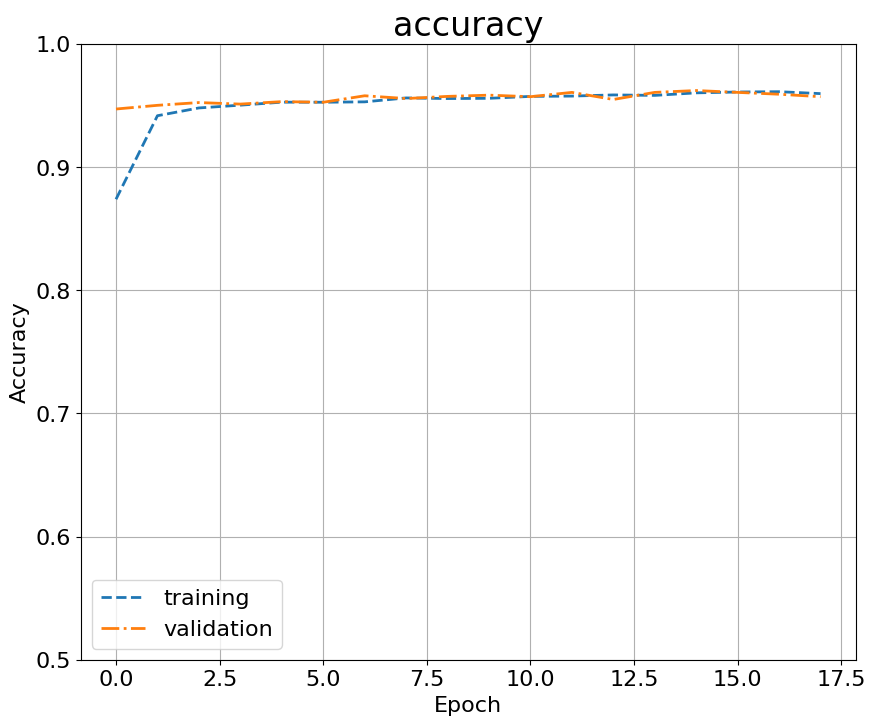

In [11]:
import matplotlib.pyplot as plt

history = np.load(f'../models/crta_models/{savename}_history.npy', 
                  allow_pickle='TRUE').item()

# LOSS
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['loss'], label='training', ls='--', lw=2)
ax.plot(history['val_loss'], label = 'validation', ls='-.', lw=2)
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Loss', fontsize=fs)
ax.set_title('loss function', fontsize=fs*1.5)
ax.set_ylim([0.0,0.2])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loss.png')

# ACCURACY
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['accuracy'], label='training', ls='--', lw=2)
ax.plot(history['val_accuracy'], label = 'validation', ls='-.', lw=2)
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Accuracy', fontsize=fs)
ax.set_title('accuracy', fontsize=fs*1.5)
ax.set_ylim([0.5,1])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_accuracy.png')

# Get separation error

In [12]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")
print(f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")
print(f"ERROR: {err.deg}")

TRUE: (175.35680516620394, 75.18494030401693)

PREDICTION: (177.13544334056505, 75.1186790021859)

ERROR: 0.46056496970531363


# Get DS separation error

In [13]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))

err_noisy = [e.degree for e in err]
len(err_noisy)

4000

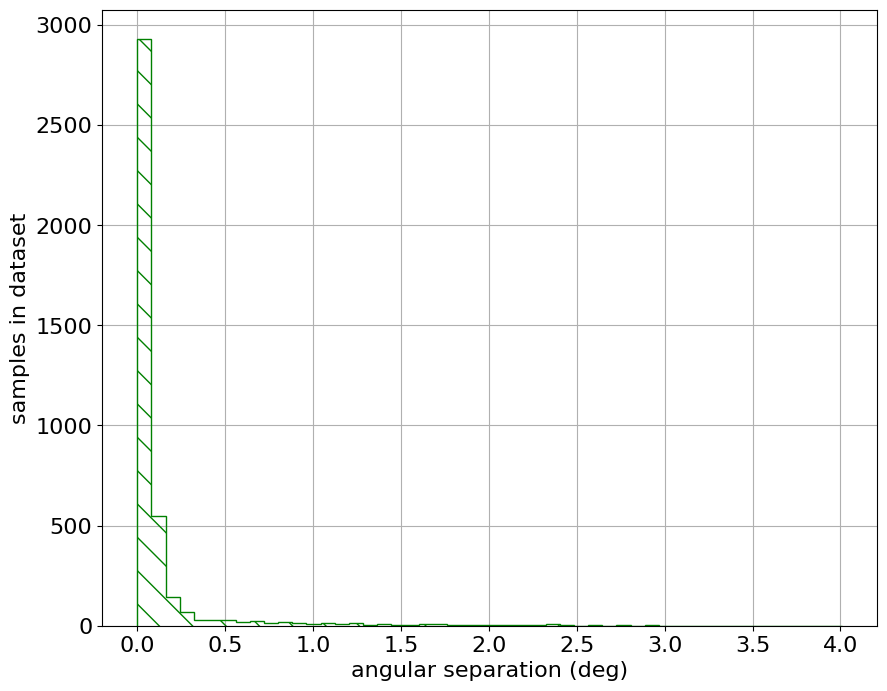

0.07004951139048085

In [14]:
import matplotlib.patches as mpatches
hatches = ['\\', '//']

fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
data = err_noisy
#ax.set_title('reconstruction error', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
#ax.legend(handles=legends, labels=labels, fontsize=fs)

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
    
plt.show()
fig.savefig(f'img/regressor_loc_error_noisy.png')

np.percentile(err_noisy, 68)

# Compare with second model

In [15]:
#savename = 'regressor_5sgm_filter6_4convs_dense1e4_z20' 
savename = 'regressor_200x200_filter2_2convs_yx'
model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
model.summary()

# predictions
predictions = model.predict(test_data) * binning
predictions[idx], test_labels[idx] * binning

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 4)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 4)         0

(array([97.91863, 89.26422], dtype=float32),
 array([116.6638822 ,  92.39841595]))

In [16]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_2nd = [e.degree for e in err]
len(err_2nd)

4000

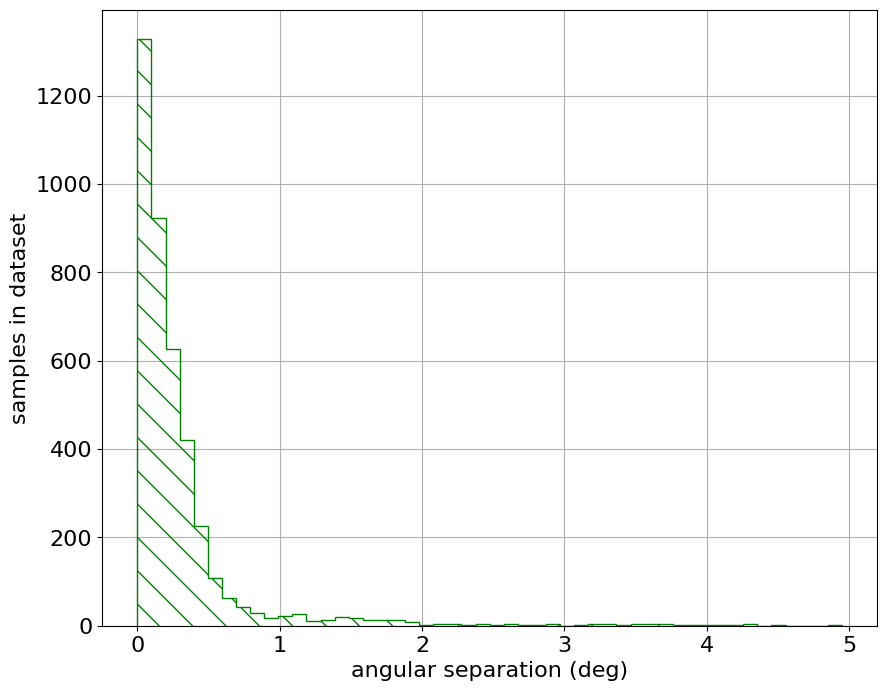

0.2718812605233787

In [17]:
hatches = ['\\', '//']

fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
data = err_2nd
#ax.set_title('reconstruction error', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 50, density=False, histtype='step', color='g', label=['cleaned model'])
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
#ax.legend(handles=legends, labels=labels, fontsize=fs)

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)
    
plt.show()
fig.savefig(f'img/regressor_loc_error_clean.png')

np.percentile(err_2nd, 68)

# Comparison hist

Model yx is the one with better improvement.

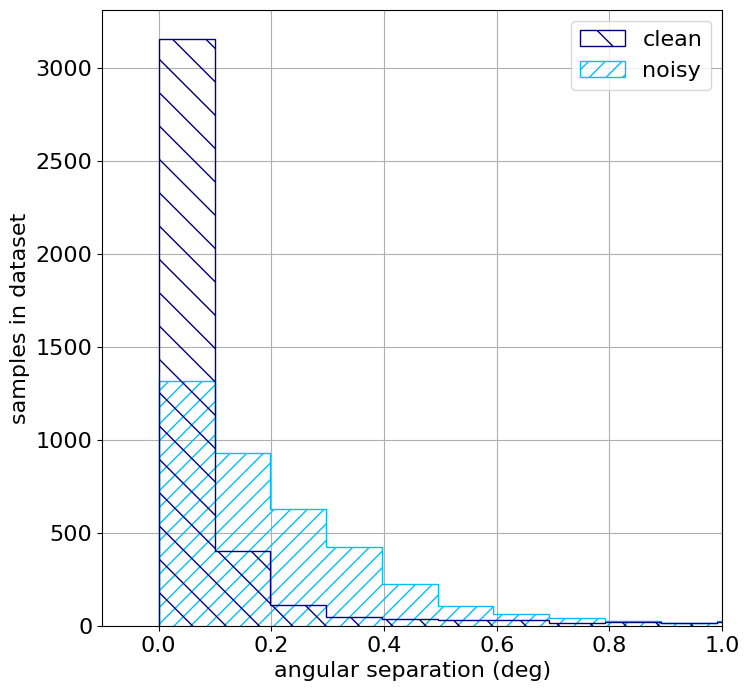

In [29]:
import matplotlib.patches as mpatches

#colors = ['darkblue', 'crimson'] 
colors = ['navy', 'deepskyblue'] 
#labels = ['zALL', 'z20']
labels = ['clean', 'noisy']
hatches = ['\\', '//']
legends = [mpatches.Patch(facecolor='none', edgecolor=colors[0], hatch=hatches[0]), 
           mpatches.Patch(facecolor='none', edgecolor=colors[1], hatch=hatches[1])]
histsize = (8,8)

fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
data = (err_noisy, err_2nd)

n, bins, patches = ax.hist(data, 50, density=False, histtype='step', color=colors, label=labels)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(handles=legends, labels=labels, fontsize=fs)
ax.set_xlim([-0.1,1])
#ax.set_ylim([0, 4000])


for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

plt.show()
fig.savefig(f'img/regressor_loc_error_noisy_vs_clean.png')

np.percentile(err_2nd, 68), np.percentile(err_noisy, 68), len(err_2nd), len(err_noisy)

# Gammapy comparison

In [19]:
gammafile = f'{path}/regressor_5sgm_xy_flip_gammapy.txt'
gammadata = pd.read_csv(gammafile, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,snr
0,1,57.267818,30.441771,NaN,NaN,NaN,NaN,NaN,NaN
1,2,98.165826,40.944170,NaN,NaN,NaN,NaN,NaN,NaN
2,3,76.894712,-66.343824,145.0,617.0,93.583333,27.604347,10.048215,3.510678
3,4,125.480814,-44.467154,189.0,708.0,138.428571,29.949958,14.058160,4.758067
4,5,214.105104,42.757503,161.0,771.0,118.166667,30.528675,13.177265,3.962811


In [20]:
err = []
seeds = gammadata['seed']
for i, seed in enumerate(seeds):
    row = infodata[infodata['seed']==seed]
    grow = gammadata[gammadata['seed']==seed]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    # found coordinates
    found_deg = {'ra': grow['loc_ra'].values[0], 'dec': grow['loc_dec'].values[0]}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_gamma = [e.degree for e in err]
len(err_noisy), len(err_gamma)

(4000, 20000)

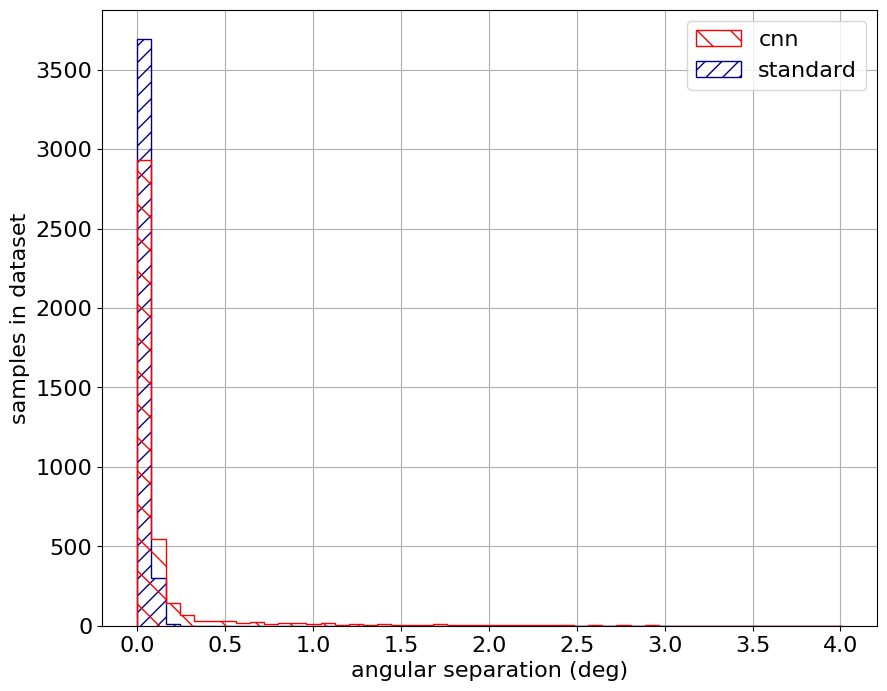

(0.04492793648050196,
 0.07004951139048085,
 0.0022525561781551726,
 0.10254785683344796)

In [21]:
#data = (err_noisy, err_clean, err_gamma)
data = (err_noisy, err_gamma[:4000])

#colors = ['darkblue', 'deepskyblue']
colors = ['red', 'navy']
hatches = ['\\', '//']
labels = ['cnn', 'standard']
legends = [mpatches.Patch(facecolor='none', edgecolor=colors[0], hatch=hatches[0]), 
           mpatches.Patch(facecolor='none', edgecolor=colors[1], hatch=hatches[1])]

fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
#ax.set_title('localisation error', fontsize=fs*1.5)
n, bins, patches = ax.hist(data, 50, density=False, histtype='step', color=colors)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(handles=legends, labels=labels, fontsize=fs)
#ax.set_xlim([-0.2,3])

for patch, hatch in zip(patches, hatches):
    plt.setp(patch, hatch=hatch)

plt.show()
fig.savefig(f'img/regressor_loc_error_cnn_vs_gp.png')

np.percentile(err_gamma[:4000], 68), np.percentile(err_noisy, 68), np.var(err_gamma[:4000]), np.var(err_noisy)